In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
import seaborn as sb

# Principal Component Analysis

### Load and standardize the data

PCA is effected by scale so you need to scale the features in your data before applying PCA. Use StandardScaler to help you standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. 

In [2]:
#Load the Dataset
df          = pd.read_csv('/Users/erichganz/Documents/University/predictive modelling/day3 Reducing dimension/letor.csv', sep=' ')
#Add the features
df_features = df[list(map(lambda x: str(x), range(1,137)))]
#Extract the values in lists
df_features = df_features.values
#standardize the values (requiered step for the PCA to work!)
df_features = StandardScaler().fit_transform(df_features)

This fuctions takes ready comptued components and a list of target variances to return the amount of components need to meet the target

In [3]:
def explained_var(components, variances):
        
    result    = []

    for variance in variances:

        accumulated_variance, i = 0, 0

        try:

            while accumulated_variance < variance:
                
                accumulated_variance += components[i]
                i += 1

        except:
            
            result.append('Attention! All our ' + str(i) + ' components are not enough explain ' + str(variance) + ' percent of the varinace!')
        
        else:
            
            result.append('We can explain ' + str(accumulated_variance) +' percent of the varinace, with ' + str(i) + ' components.')

    return result

Here I built the PCA model

In [4]:
from sklearn.decomposition import PCA

#Get an empty PCA object with 50 components
current_PCA = PCA(n_components=50)
#Fit the empty model to out normalized data - reduce or normalized data
current_PCA.fit_transform(df_features)
#Define our target variances
variances = [0.75,0.8,0.95,0.99]
#Get the number of component to meet our target variances
explained_var(current_PCA.explained_variance_ratio_, variances)

['We can explain 0.7654736481923817 percent of the varinace, with 13 components.',
 'We can explain 0.8057508691682914 percent of the varinace, with 16 components.',
 'We can explain 0.9530997330453146 percent of the varinace, with 38 components.',
 'Attention! All our 50 components are not enough explain 0.99 percent of the varinace!']

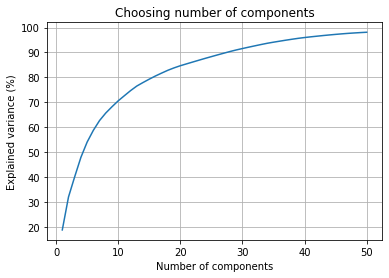

In [5]:
plt.plot(range(1,50+1), 100 * np.cumsum(current_PCA.explained_variance_ratio_))
plt.title('Choosing number of components')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.grid()

Looking at this graph I decied to take as a cutoff the first n components which's variance explaination are more than the avarage explaination of all components.

In [6]:
avarage_explaination = sum(current_PCA.explained_variance_ratio_)/50

def get_cutoff(avg, components):
    
    explained = 0
    i = 0

    while components[i] > avg:

        explained += components[i]
        i += 1

    return i, explained

get_cutoff(avarage_explaination, current_PCA.explained_variance_ratio_)

(12, 0.747190645615921)

Therefore I would select the first 12 components

# Factor Analysis

In [7]:
#Looking at the data in excel I saw that na_values = '#NULL!'
df = pd.read_excel("/Users/erichganz/Documents/University/predictive modelling/day3 Reducing dimension/personality.xlsx", na_values = '#NULL!')
#Here I deleat all rows which have only na values
df = df.dropna(how='all')
#Here I replace all single na values with the median
for column in df.columns: df[column].fillna(df[column].median(), inplace=True)

<AxesSubplot:>

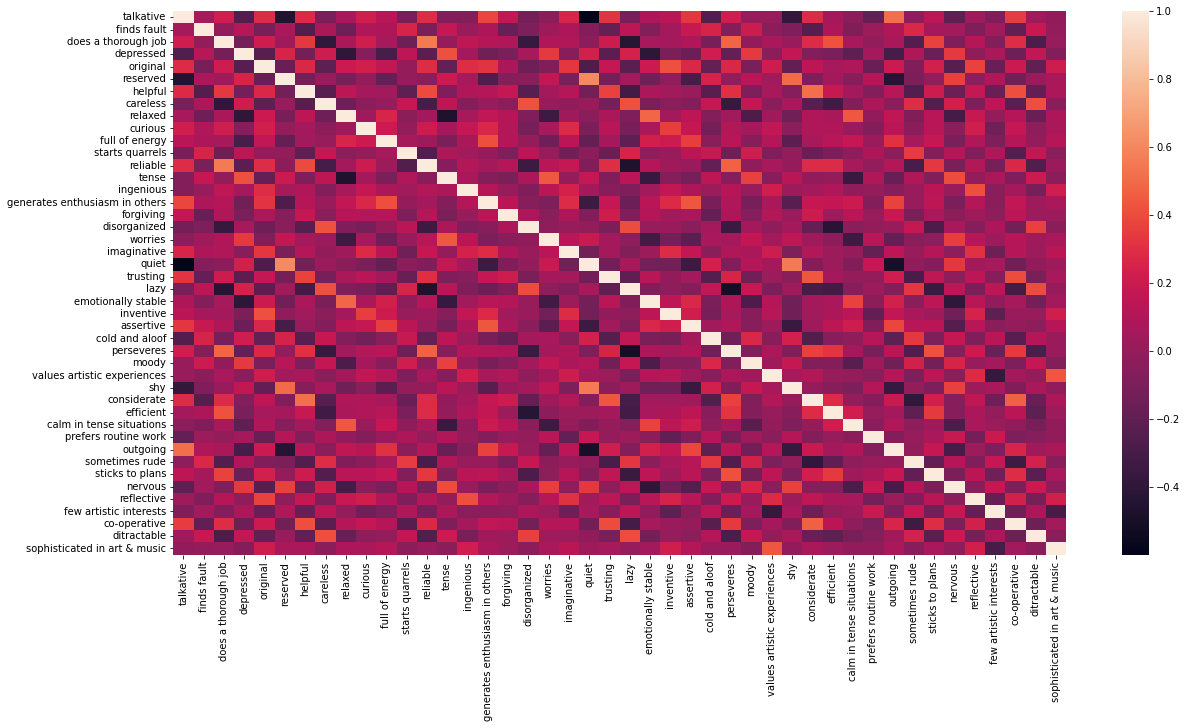

In [8]:
plt.figure(figsize=(20,10))
c = df.corr()
sb.heatmap(c)

Resulting from the following tests we refuse H0 of our var-cover matrix to be identity. 

In [9]:
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value, p_value = calculate_bartlett_sphericity(df)
print('Bartlett: ', chi_square_value, p_value)

kmo_all,kmo_model = calculate_kmo(df)
print('KMO: ',kmo_model)

Bartlett:  6730.695392329847 0.0
KMO:  0.8382867932626757


This said, we continue looking at the eigenvalues.

In [10]:
fa = FactorAnalyzer()
fa.fit(df)
#Get Eigenvalues
ev, v = fa.get_eigenvalues()
ev


array([7.07473998, 4.06104375, 2.96982259, 2.52889732, 2.20230876,
       1.61608231, 1.32497671, 1.22373377, 1.12485682, 1.08206825,
       0.9549272 , 0.94020828, 0.91602907, 0.87740832, 0.8249334 ,
       0.77041973, 0.74529799, 0.7271257 , 0.69142943, 0.67585809,
       0.65047633, 0.63990529, 0.60831623, 0.59053836, 0.57121334,
       0.56840891, 0.54526084, 0.50485325, 0.49931539, 0.47844895,
       0.46105022, 0.43852522, 0.42452329, 0.41832279, 0.4075696 ,
       0.3908342 , 0.37344451, 0.3542288 , 0.34742206, 0.32790499,
       0.30692476, 0.28498487, 0.25792274, 0.21743757])

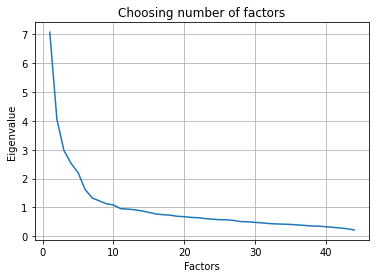

In [11]:
#Plot eigenvalues
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Choosing number of factors')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()

We will only use 10 factors here with eigenvalues 7.07473998, 4.06104375, 2.96982259, 2.52889732, 2.20230876,
       1.61608231, 1.32497671, 1.22373377, 1.12485682, 1.08206825

# Random Forrest For Dimension Reduction

Data loading and imputation

In [12]:
#Looking at the data in excel I saw that na_values = '..'
df = pd.read_excel("/Users/erichganz/Documents/University/predictive modelling/day2/CountriesWorldIndicators2019.xlsx", na_values = '..')

#Randome forest as dimension reduction needs a target variable. I used the incomegroup as a target. 
#Note that I didn't used dummies but gcreated a nominal ranking accoring to their income group
rateing = dict( zip(list(df['Income Group'].unique()), [0,2,1,3]) )
df['Income Group'].replace(rateing, inplace=True)

y = df['Income Group']
x = df.drop(['Income Group', 'Country Name', 'Country Code', 'Region'], axis=1)

#I checked the data before in excel and noticed that there are sometimes single cells missing. But 
#never a row or column. Here I replace all single na values with the median
for column in x.columns: x[column].fillna(x[column].median(), inplace=True)

Building a Randome Forest for dimension reduction

In [13]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(x,y)

features = x.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features

This plot shows use the 10 most common features which where selected for the split of nodes based on the Information criteria, as described in my presentation. Remember that I chose the income group of country as the target variable. Therefore it was to expactable that GDP per capita will be ranked high among those the features.

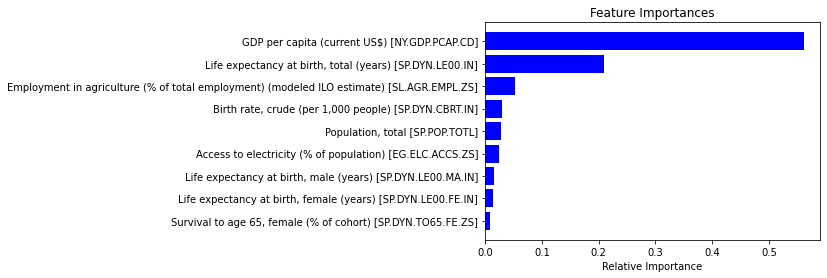

In [14]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

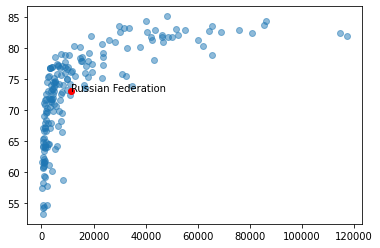

In [15]:
N = len(df[ 'GDP per capita (current US$) [NY.GDP.PCAP.CD]'])
com_1 = df[ 'GDP per capita (current US$) [NY.GDP.PCAP.CD]']
com_2 = df['Life expectancy at birth, total (years) [SP.DYN.LE00.IN]']
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

fig, ax = plt.subplots()
plt.scatter(com_1, com_2, alpha=0.5)
plt.scatter(com_1[161], com_2[161], c='red')

for i, txt in enumerate(['' if name != 'Russian Federation' else 'Russian Federation' for name in df['Country Name']] ):
    ax.annotate(txt, (com_1[i], com_2[i]))

Here I compare it with the result of a PCA. The PCA method gives us a very clear choice of component selection. Either pick only one or two computed component. I would select the first two components.

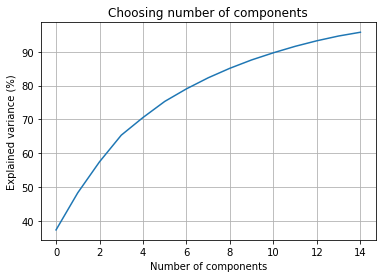

In [16]:
from sklearn.decomposition import PCA


#standardize the values (requiered step for the PCA to work!)
x = StandardScaler().fit_transform(x.values)
#Get an empty PCA object with 50 components
current_PCA = PCA(n_components=15)
#Fit the empty model to out normalized data - reduce or normalized data
components = current_PCA.fit_transform(x)
principalDf = pd.DataFrame(data = components, columns = ['component' + str(i+1) for i in range(15)])

plt.plot(range(0,15), 100 * np.cumsum(current_PCA.explained_variance_ratio_))
plt.title('Choosing number of components')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.grid()


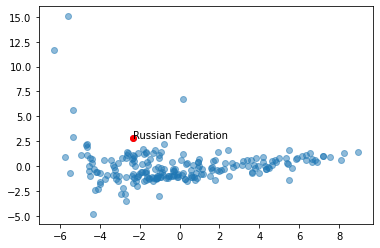

In [17]:
N = len(current_PCA.components_[0])
x = principalDf['component1'].values
y = principalDf['component2'].values

fig, ax = plt.subplots()
plt.scatter(x, y, alpha=0.5)
plt.scatter(x[161], y[161], c='red')

for i, txt in enumerate(['' if name != 'Russian Federation' else 'Russian Federation' for name in df['Country Name']] ):
    ax.annotate(txt, (x[i], y[i]))